# Introduction

###  “Picture yourself strolling through your local, open-air market… What do you see? What do you smell? What will you make for dinner tonight?”

- The objective of this dataset presented in the Kaggle Competition is to predict the category of a dish's cuisine given a list of its ingredients. 

- Some of our strongest geographic and cultural associations are tied to a region’s local foods hence a list of ingredients would be a clue to which cuisine that dish belongs

- The dataset contains 20 international cuisines from **Yummly.** 
- Yummly is a mobile app and website that provides recipe recommendations personalized to the individual's tastes, semantic recipe search, a digital recipe box, shopping list and one-hour grocery delivery
- The train dataset contains 39774 dish-ids along with their ingredients and cuisine label. The test data contains 9944 dish-ids along with their ingredients. **Our task is to predict cuisine for a particular dish from test data given its ingredient set.**

- The data is stored in JSON format. 
    - An example of a recipe node in train.json:
    
            {
             "id": 38714,
             "cuisine": "indian",
             "ingredients": [
             "ice cubes",
             "vanilla extract",
             "honey",
             "ground cardamom",
             "ground cinnamon",
             "1% low-fat milk",
             "nonfat yogurt",
             "mango"
             ]
             }


# Importing Libraries

In [ ]:
#Library install commands:
#!pip install chart_studio
#!pip install plotly==4.1.0
#pip install wordcloud
#pip install nltk

In [ ]:
# Data processing 
import pandas as pd
import json
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re


# Data vizualizations
import random
import chart_studio.plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from wordcloud import WordCloud, STOPWORDS  


from nltk.stem import WordNetLemmatizer
from itertools import chain

# Load Dataset

In [ ]:
train = pd.read_json('train.json') # store as dataframe objects

In [ ]:
train.shape

(39774, 3)

In [ ]:
train.head()

cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian  22213                [water, vegetable oil, wheat, salt]
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


The train data provided is in json format. 

We have imported the data as a data frame object  We observe that each recipe is a separate row and has:

- a unique identifier - the 'id' column;
- the type of cuisine in which this recipe falls - this is our target variable (the test sample does not have this column);
- a list object with ingredients (the recipe) - this will be the main source of explanatory variables in our classification problem.

**Problem statement:** Predict the type of cuisine based on given data (ingredients). This is a classification task which requires text processing and analysis.

# Data Exploration

### <u>Lets first explore the target variable - Cuisine</u>
###  Number of Unique Cuisines

In [ ]:
print("Number of cuisines: {}".format(len(train.cuisine.unique())))
train.cuisine.unique()

Number of cuisines: 20


array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

There are 20 different cuisines (categories) which we are going to predict. 
This means that the problem at hand is a multi-class classification (there are more than 2 categories to predict). 

### Cuisine Distribution

Text(0.5, 1.0, 'Cuisine Distribution')

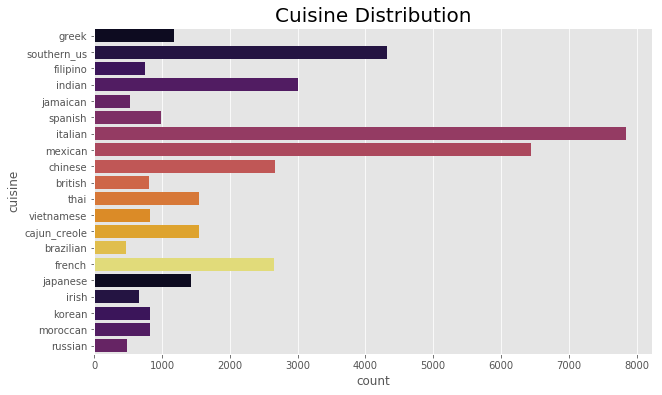

In [ ]:
sns.countplot(y='cuisine', data=train,palette=sns.color_palette('inferno',15))
plt.gcf().set_size_inches(10,6)
plt.title('Cuisine Distribution',size=20)

### Let us define a function for generating colours at random - it will be used for vizualization in the analysis

In [ ]:
def random_colours(number_of_colors):
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

### Cuisine distributuion in terms of Percentage

In [ ]:
#  Label distribution in percents
recipepercent = []
for i in train.cuisine.value_counts():
    percent = (i/sum(train.cuisine.value_counts()))*100  # number of particular cuisine/total number of cuisines
    percent = "%.2f" % percent
    percent = str(percent + '%')
    recipepercent.append(percent)

In [ ]:
trace = go.Bar(
            x=train.cuisine.value_counts().values[::-1], 
            y= [i for i in train.cuisine.value_counts().index][::-1],
            text =recipepercent[::-1],  textposition = 'outside', 
            orientation = 'h',marker = dict(color = random_colours(20)))
layout = go.Layout(title='Percentage of recipes in each cuisine category',
                   titlefont = dict(size = 20),
                   width=900, height=400, 
                   plot_bgcolor = 'rgba(0,0,0,0)',# RGBA color values are an extension of RGB color values with an alpha channel 
                                                  # which specifies the opacity for a color.
                   paper_bgcolor = 'rgba(255, 219, 227, 0.88)',
                   margin=dict(l=75,r=80,b=50,t=60),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
plot(fig, filename='horizontal-bar')

c:\stan\programs\python\lib\site-packages\plotly\offline\offline.py:562: UserWarning:

Your filename `horizontal-bar` didn't end with .html. Adding .html to the end of your file.



'horizontal-bar.html'

#### Let us Creating a table giving information on the number of times each cuisine is represented in the training sample

In [ ]:
trace = go.Table(
                header=dict(values=['Cuisine','Number of recipes'],
                fill = dict(color=['#EABEB0']), 
                align = ['center'] * 5),
                cells=dict(values=[train.cuisine.value_counts().index,train.cuisine.value_counts()],
               align = ['center'] * 5))

layout = go.Layout(title='Number of Recipes in each Cuisine ',
                   titlefont = dict(size = 20),
                   width=500, height=650, 
                   paper_bgcolor =  'rgba(0,0,0,0)',
                   plot_bgcolor = 'rgba(0,0,0,0)',
                   autosize = False,
                   margin=dict(l=20,r=20,b=1,t=50,pad=2),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
plot(fig)

'temp-plot.html'

 
  #### The presence of Italian cuisine is maximum in train data

### <u> Let us explore the Ingredients in our dataset </u>
### Number of ingredients in each recipe

In [ ]:
train_df = train.copy()
train_df['ingredients_text'] = train_df['ingredients'].apply(lambda x: ', '.join(x))
train_df['num_ingredients'] = train_df['ingredients'].apply(lambda x: len(x))
train_df.head()

cuisine     id                                        ingredients  \
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...   
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...   
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3       indian  22213                [water, vegetable oil, wheat, salt]   
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...   

                                    ingredients_text  num_ingredients  
0  romaine lettuce, black olives, grape tomatoes,...                9  
1  plain flour, ground pepper, salt, tomatoes, gr...               11  
2  eggs, pepper, salt, mayonaise, cooking oil, gr...               12  
3                  water, vegetable oil, wheat, salt                4  
4  black pepper, shallots, cornflour, cayenne pep...               20

### Maximum and Minimum Number of Ingredients

In [ ]:
print('Maximum Number of Ingredients in a Recipe: ',train['ingredients'].str.len().max())
print('Minimum Number of Ingredients in a Recipe: ',train['ingredients'].str.len().min())
print('Mean of Ingredients in a Recipe: ',train['ingredients'].str.len().mean())


Maximum Number of Ingredients in a Recipe:  65
Minimum Number of Ingredients in a Recipe:  1
Mean of Ingredients in a Recipe:  10.76771257605471


### Distribution of Recipe length

In [ ]:
trace = go.Histogram(
    x= train['ingredients'].str.len(),
    xbins=dict(start=0,end=80,size=1),
   marker=dict(color='MediumPurple'),
    opacity=1)
data = [trace]
layout = go.Layout(
    title='Distribution of Recipe Length',
    xaxis=dict(title='Number of ingredients'),
    yaxis=dict(title='Count of recipes'),
    bargap=0.1,
    bargroupgap=0.2)

fig = go.Figure(data=data, layout=layout)
plot(fig)

'temp-plot.html'

**The distribution of recipe length is right-skewed**

 #### Lets find the number of  recipies which has more than 30 ingredients and less than 10 ingredients

In [ ]:
lengthy_recipies = train[train['ingredients'].str.len() > 30]
short_recipes = train[train['ingredients'].str.len() <= 2]
one_ingre = train[train['ingredients'].str.len() == 1]
print("We have {} recipes in the train set which have more than 30 ingredients ".format(len(lengthy_recipies)))
print("We have {} recipes in the train set which have less than or equal to 2 ingredients ".format(len(short_recipes)))
print("We have {} recipes in the train set which have just one ingredient ".format(len(one_ingre)))

We have 40 recipes in the train set which have more than 30 ingredients 
We have 215 recipes in the train set which have less than or equal to 2 ingredients 
We have 22 recipes in the train set which have just one ingredient 


 #### Let's explore the ingredients in the lengthy and the short recipe and also their corresponding cuisine.

In [ ]:
print("The ingredients in the longest recipe in our training set which is 65 ingredients." + "\n")
print("They are"+ "\n")
print(str(list(lengthy_recipies[lengthy_recipies['ingredients'].str.len() == 65].ingredients.values)) + "\n")
print("And the corresponding cuisine is: " + str(list(lengthy_recipies[lengthy_recipies['ingredients'].str.len() == 65].cuisine)))

The ingredients in the longest recipe in our training set which is 65 ingredients.

They are

[['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'NeufchÃ¢tel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-d

In [ ]:
print("The ingredients in the shortest recipe in our training set is the recipe with just one ingredient." + "\n")
print("They are"+ "\n")
print(str(list(short_recipes[short_recipes['ingredients'].str.len() == 1].ingredients.values)) + "\n")
print("And the corresponding Cuisines are: " 
      + str(list(short_recipes[short_recipes['ingredients'].str.len() == 1].cuisine)))

The ingredients in the shortest recipe in our training set is the recipe with just one ingredient.

They are

[['sushi rice'], ['dried rice noodles'], ['plain low-fat yogurt'], ['unsalted butter'], ['udon'], ['sticky rice'], ['butter'], ['corn tortillas'], ['grained'], ['lemonade concentrate'], ['jasmine rice'], ['unsalted butter'], ['cherry tomatoes'], ['butter'], ['cumin seed'], ['haricots verts'], ['vegetable oil'], ['spanish chorizo'], ['sweetened condensed milk'], ['water'], ['phyllo'], ['unsalted butter']]

And the corresponding Cuisines are: ['japanese', 'vietnamese', 'indian', 'indian', 'japanese', 'thai', 'indian', 'mexican', 'thai', 'southern_us', 'thai', 'indian', 'italian', 'french', 'indian', 'french', 'mexican', 'spanish', 'spanish', 'japanese', 'greek', 'indian']


### Distribution of recipe length by cuisine

In [ ]:
boxplotcolors = random_colours(23)
labels = [i for i in train.cuisine.value_counts().index][::-1]
data = []
for i in range(20):
    trace = go.Box(
    y=train[train['cuisine'] == labels[i]]['ingredients'].str.len(), name = labels[i],
    marker = dict(color = boxplotcolors[i]))
    data.append(trace)
layout = go.Layout(
    title = "Recipe Length Distribution by cuisine"
)

fig = go.Figure(data=data,layout=layout)
plot(fig, filename = "Box Plot Styling Outliers")

c:\stan\programs\python\lib\site-packages\plotly\offline\offline.py:562: UserWarning:

Your filename `Box Plot Styling Outliers` didn't end with .html. Adding .html to the end of your file.



'Box Plot Styling Outliers.html'

### List of all ingredients used in all recipies

In [ ]:
all_ingredients =[]
for recipe in train["ingredients"]:
    for ingre in recipe:
        all_ingredients.append(ingre)
print("The number of ingredients present (including duplicates) in all recipes is :", len(all_ingredients))    

The number of ingredients present (including duplicates) in all recipes is : 428275


### Count of number of times each ingredient occurs

In [ ]:
ingre_count = Counter()
for ingre in all_ingredients:
     ingre_count[ingre] += 1


In [ ]:
# Most Common ingredients 
print("The top twentyfive most commonly used ingredients are:"+"/n")
print(ingre_count.most_common(25))


# Count of unique ingredients
print("The number of ingredients is",len(ingre_count))


The top twentyfive most commonly used ingredients are:/n
[('salt', 18049), ('onions', 7972), ('olive oil', 7972), ('water', 7457), ('garlic', 7380), ('sugar', 6434), ('garlic cloves', 6237), ('butter', 4848), ('ground black pepper', 4785), ('all-purpose flour', 4632), ('pepper', 4438), ('vegetable oil', 4385), ('eggs', 3388), ('soy sauce', 3296), ('kosher salt', 3113), ('green onions', 3078), ('tomatoes', 3058), ('large eggs', 2948), ('carrots', 2814), ('unsalted butter', 2782), ('ground cumin', 2747), ('extra-virgin olive oil', 2747), ('black pepper', 2627), ('milk', 2263), ('chili powder', 2036)]
The number of ingredients is 6714


### Top 25 most commonly used ingredients

In [ ]:
# to visualize top 25 most commonly usedingredients

most_common_ingre = [ingre[0] for ingre in ingre_count.most_common(25)]
#most_common_ingre
most_common_ingre_count = [ingre[1] for ingre in ingre_count.most_common(25)]
#most_common_ingre_count

In [ ]:
trace = go.Bar(
            x=most_common_ingre_count[::-1],
            y= most_common_ingre[::-1],
            orientation = 'h',marker = dict(color = random_colours(28),
))
layout = go.Layout(
    xaxis = dict(title= 'Number of occurences of ingredients in all recipes ', ),
    yaxis = dict(title='Ingredient',),
    title= 'Top 25 Most Commonly Used Ingredients',  titlefont = dict(size = 20),
    margin=dict(l=15,r=10,b=60,t=60,pad=5),
    width=800, height=500, 
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='horizontal-bar')

'horizontal-bar.html'

# Visualization using Wordcloud

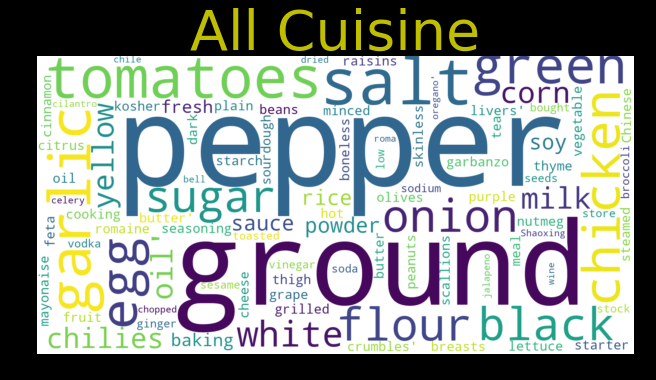

In [ ]:

stopwords = set(STOPWORDS)
size = (20,10)

def cloud(text, title, stopwords=stopwords, size=size):  
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    plt.rcParams['figure.figsize']=(10.0,10.0)
    plt.rcParams['font.size']=10
    plt.rcParams['savefig.dpi']=100
    plt.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                         ).generate(str(text))        #  create and generate a word cloud image:
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80,facecolor='k', edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()

# Data Set for Word Clouds
train["ing"] = train.ingredients.apply(lambda x: list(map(str, x)), 1).str.join(' ')
# All
cloud(train["ing"].values, title="All Cuisine", size=[8,6])

Cuisine WordClouds


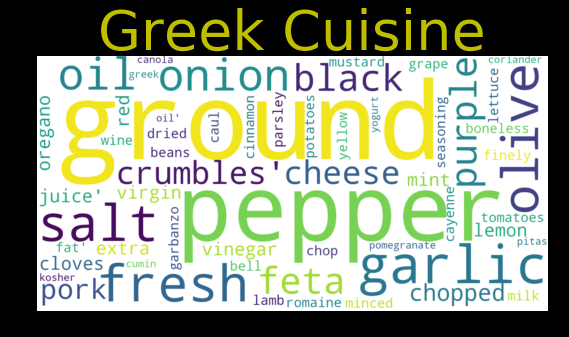

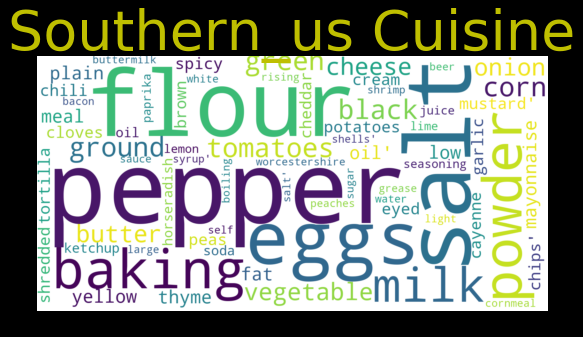

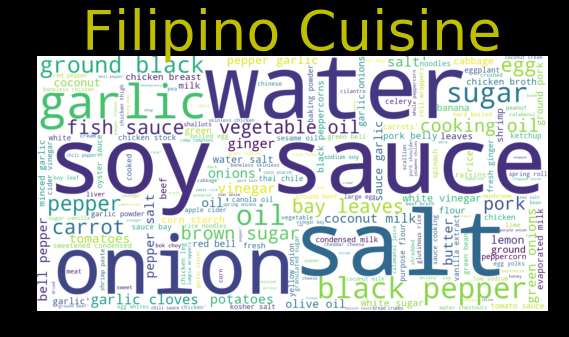

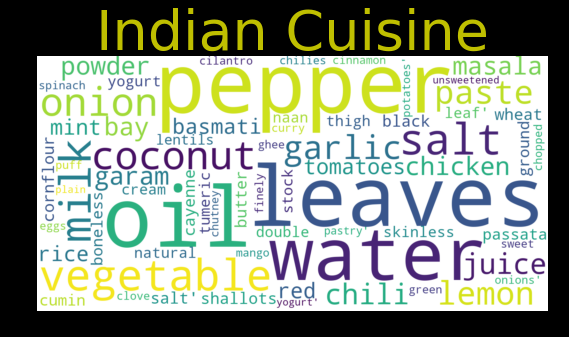

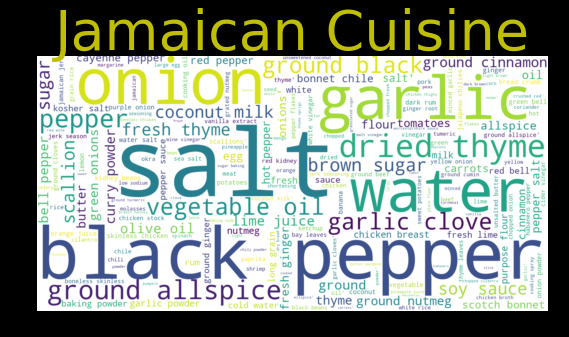

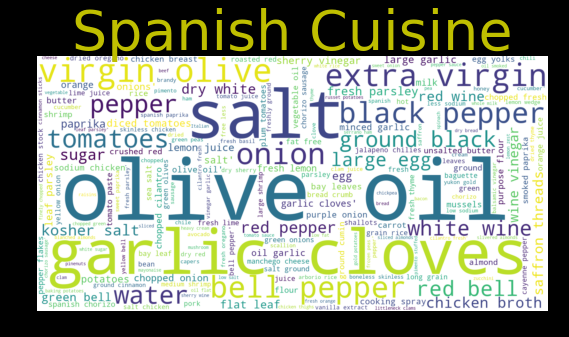

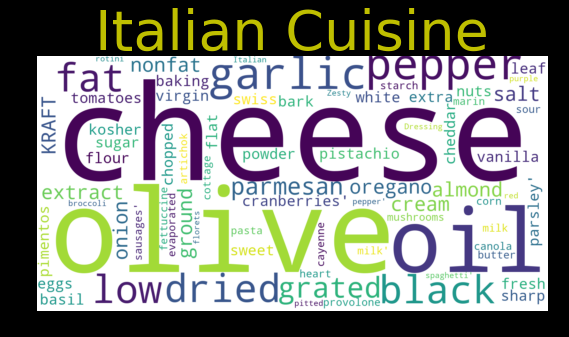

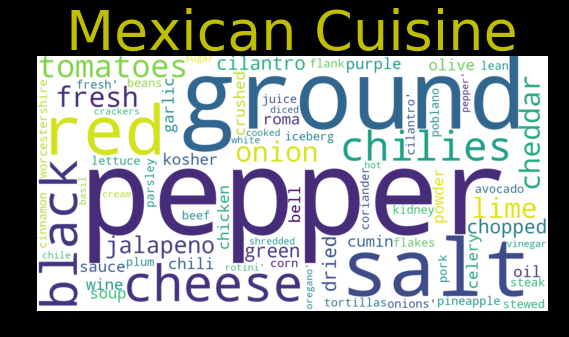

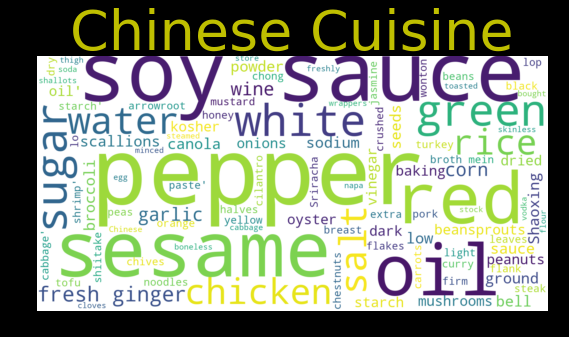

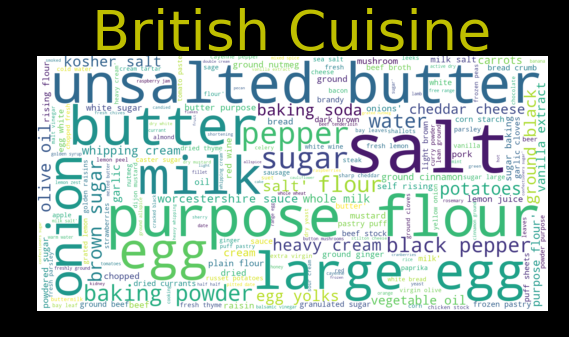

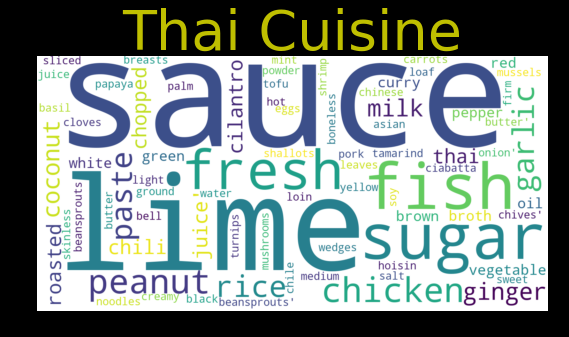

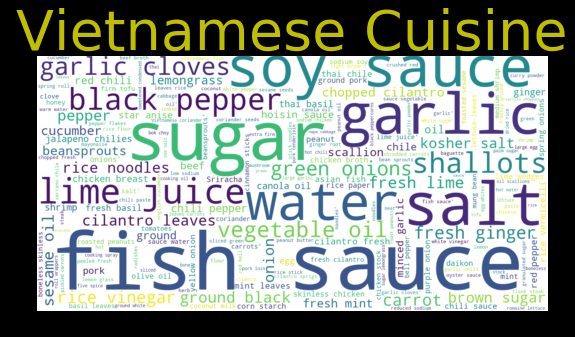

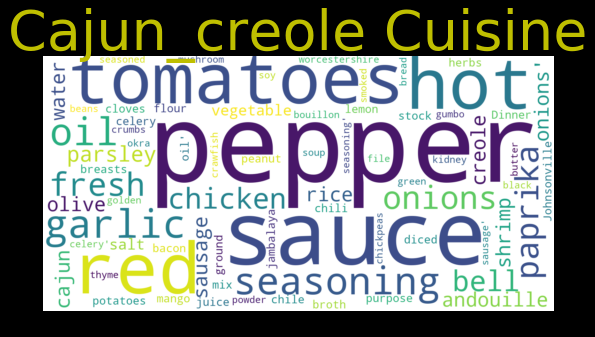

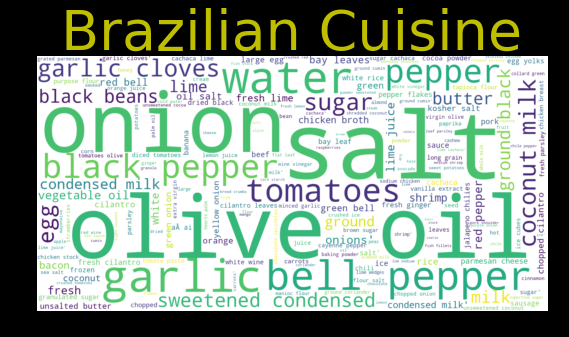

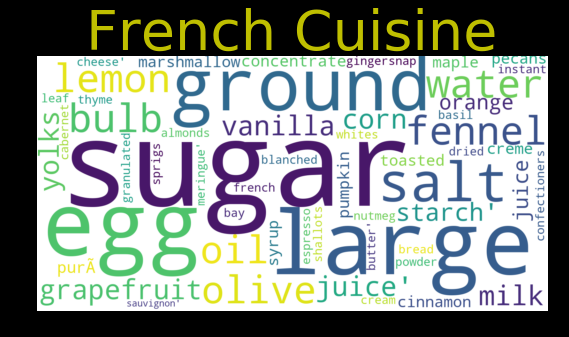

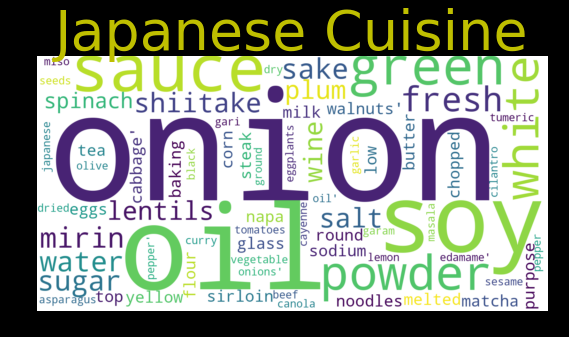

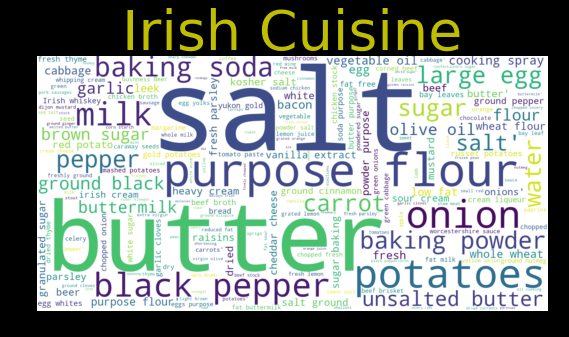

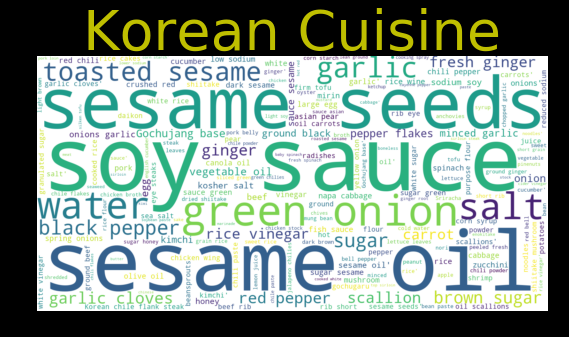

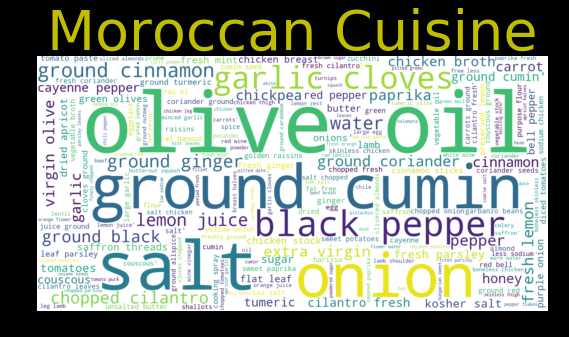

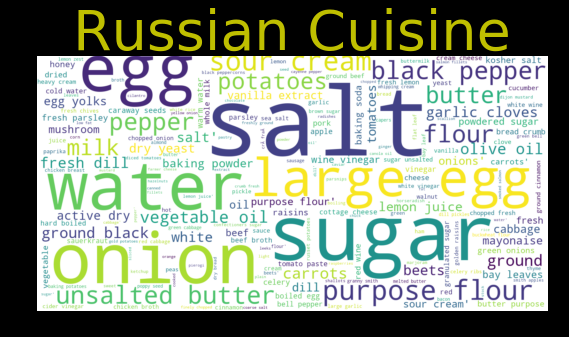

In [ ]:
print("Cuisine WordClouds")
traindex = train.index
train_data = train.copy()
y = train.cuisine.copy()

cloud_df = pd.concat([train_data.loc[traindex,'ing'], y],axis=1)
for cuisine_x in y.unique():
    cloud(cloud_df.loc[cloud_df.cuisine == cuisine_x, "ing"].values, title="{} Cuisine".format(cuisine_x.capitalize()), size=[8,4])
train_data.drop('ing',axis=1,inplace=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer=lambda x: [i.strip() for i in x.split(',')], lowercase=False)
dummies = vect.fit_transform(train['ingredients'].apply(','.join)) 

df = pd.DataFrame(dummies.todense(),columns=vect.get_feature_names())
print("Vocab Length: ", len(vect.get_feature_names()))
print("All Data Shape: ", df.shape)

Vocab Length:  6724
All Data Shape:  (39774, 6724)


# Outliers

#### First let us check for the following
1. Number of recipes with just one ingredients
2. Number of ingredients with just 2 characters

### Number of recipe with just one ingredient

In [ ]:
print("The number of recipe with just one ingredient ",len(train_df[train_df["num_ingredients"] <= 1]))
train_df[train_df["num_ingredients"] <= 1]

The number of recipe with just one ingredient  22


cuisine     id                 ingredients  \
940       japanese   4734                [sushi rice]   
2088    vietnamese   7833        [dried rice noodles]   
6787        indian  36818      [plain low-fat yogurt]   
7011        indian  19772           [unsalted butter]   
8181      japanese  16116                      [udon]   
8852          thai  29738               [sticky rice]   
8990        indian  41124                    [butter]   
10506      mexican  32631            [corn tortillas]   
13178         thai  29570                   [grained]   
17804  southern_us  29849      [lemonade concentrate]   
18136         thai  39186              [jasmine rice]   
18324       indian  14335           [unsalted butter]   
21008      italian  39221           [cherry tomatoes]   
22119       french  41135                    [butter]   
22387       indian  36874                [cumin seed]   
23512       french  35028            [haricots verts]   
26887      mexican  18593             [vegetable oil]   
29294      spanish   7460           [spanish chorizo]   
30636      spanish  32772  [sweetened condensed milk]   
32105     japanese  12805                     [water]   
34531        greek  10816                    [phyllo]   
37220       indian  27192           [unsalted butter]   

               ingredients_text  num_ingredients  
940                  sushi rice                1  
2088         dried rice noodles                1  
6787       plain low-fat yogurt                1  
7011            unsalted butter                1  
8181                       udon                1  
8852                sticky rice                1  
8990                     butter                1  
10506            corn tortillas                1  
13178                   grained                1  
17804      lemonade concentrate                1  
18136              jasmine rice                1  
18324           unsalted butter                1  
21008           cherry tomatoes                1  
22119                    butter                1  
22387                cumin seed                1  
23512            haricots verts                1  
26887             vegetable oil                1  
29294           spanish chorizo                1  
30636  sweetened condensed milk                1  
32105                     water                1  
34531                    phyllo                1  
37220           unsalted butter                1

### Ingredients with just 2 characters

In [ ]:
all_ingredients = [ingredient for ingredients in train.ingredients.values for ingredient in ingredients]
#len(raw_ingredients)
[ingredient for ingredient in  all_ingredients if len(ingredient) <= 2]

['mi', 'mi', 'v8', 'v8']

- From above, it is clear that the recipe with just one ingredient and the ingredient with just two characters do not make sense. So we can consider them as outliers .

### Let us also check  for following 
1. Special Characters
2. Upper Cases
3. Apostrophe
4. Hyphen
5. Numbers
6. Units

### Special Characters

In [ ]:
Special_characters=' '.join(sorted([char for char in set(' '.join(all_ingredients)) if re.findall('[^A-Za-z]', char)]))
# re.findall() returns all non-overlapping matches of pattern in string
# [^A-Za-z] matches all strings that contain a non-letter
print("Special Characters are :",Special_characters)

Special Characters are :   ! % & ' ( ) , - . / 0 1 2 3 4 5 6 7 8 9 ¢ § ¨ © ¬ ­ ® º Â Ã â ‚ „ € ™


### Upper Cases

In [ ]:
upper_cases=list(set([ingredient for ingredient in all_ingredients if re.findall('[A-Z]+', ingredient)]))
print("There are {} ingredients that start with Uppercase".format(len(upper_cases)))
upper_cases[:10]

There are 499 ingredients that start with Uppercase


['Spanish smoked paprika',
 'Reblochon',
 'A Taste of Thai Rice Noodles',
 'Kraft Big Slice Pepper Jack Cheese Slices',
 'Fuyu persimmons',
 'Doritos Tortilla Chips',
 'Godiva Chocolate Liqueur',
 'Ciabatta rolls',
 'Progressoâ„¢ Chicken Broth',
 'Manischewitz Matzo Meal']

### Apostrophe

In [ ]:
apostrophe = list(set([ingredient for ingredient in all_ingredients if "'" in ingredient]))
print("There are {} ingredients which contain apostrophe".format(len(apostrophe)))
apostrophe

There are 31 ingredients which contain apostrophe


["I Can't Believe It's Not Butter!Â® All Purpose Sticks",
 "soft goat's cheese",
 "Old El Pasoâ„¢ Thick 'n Chunky salsa",
 "Uncle Ben's Original Converted Brand rice",
 "i can't believ it' not butter! made with olive oil spread",
 "Quorn Chik''n Tenders",
 "Frank'sÂ® RedHotÂ® Original Cayenne Pepper Sauce",
 "Uncle Ben's Ready Rice Whole Grain Brown Rice",
 "JOHNSONVILLEÂ® Hot 'N Spicy Brats",
 "Piment d'Espelette",
 "za'atar",
 "I Can't Believe It's Not Butter!Â® Spread",
 "Eggland's BestÂ® eggs",
 "M&M's Candy",
 "Campbell's Condensed Tomato Soup",
 "BREAKSTONE'S Sour Cream",
 "pig's trotters",
 "Colman's Mustard Powder",
 "Campbell's Condensed Cream of Chicken Soup",
 "devil's food cake mix",
 "hellmann' or best food real mayonnais",
 "Potatoes O'Brien",
 "Hellmann''s Light Mayonnaise",
 "Campbell's Condensed Cheddar Cheese Soup",
 "hellmann' or best food light mayonnais",
 "Hellmann'sÂ® Real Mayonnaise",
 "Best Food's Mayonnaise with Lime Juice",
 "Cox's Orange Pippin",
 "Hellmann'

### Hyphen

In [ ]:
hyphen = list(set([ingredient for ingredient in all_ingredients if re.findall('-', ingredient)]))
print("There are {} ingredients which contain hyphen".format(len(hyphen)))
hyphen[:5]

There are 237 ingredients which contain hyphen


['low-fat balsamic vinaigrette',
 'low-fat flour tortillas',
 'gluten-free penne',
 'vanilla low-fat frozen yogurt',
 'low-fat yogurt']

### Numbers

In [ ]:
numbers = list(set([ingredient for ingredient in all_ingredients if re.findall('[0-9]', ingredient)]))[:5]
print("There are {} ingredients which contain numbers".format(len(numbers)))
numbers

There are 5 ingredients which contain numbers


['YoplaitÂ® Greek 100 blackberry pie yogurt',
 'Tipo 00 flour',
 '(14.5 oz.) diced tomatoes',
 '(10 oz.) frozen chopped spinach',
 'licor 43']

### Units

In [ ]:
from ipywidgets import interact
# autogenerates UI controls for function arguments, and then calls the function with those arguments 
# when you manipulate the controls interactively
import ipywidgets as widgets
# Widgets are eventful python objects that have a representation in the browser,
# often as a control like a slider, textbox, etc
# to build interactive GUIs for the notebooks

units = ['inch', 'oz', 'lb', 'ounc', '%','g','tbsp','ml','tp'] # ounc is a misspelling of ounce

@interact(unit=units)
def f(unit):
    ingredients_df = pd.DataFrame([ingredient for ingredient in all_ingredients if unit in ingredient], columns=['ingredient'])
    return ingredients_df.groupby(['ingredient']).size().reset_index(name='count').sort_values(['count'], ascending=False)

interactive(children=(Dropdown(description='unit', options=('inch', 'oz', 'lb', 'ounc', '%', 'g', 'tbsp', 'ml'…

# Cleaning

In [ ]:
#from itertools import chain


def clean_ingredient(ingredient):
    
    ingredient = str.lower(ingredient)    # converts ingredient To lowercase

    # To Remove some special characters
    ingredient = ingredient.replace('&', '').replace('(', '').replace(')','')
    ingredient = ingredient.replace('\'', '').replace('\\', '').replace(',','')
    ingredient = ingredient.replace('.', '').replace('%', '').replace('/','')
    ingredient = ingredient.replace('ml', '').replace('tp', '').replace('/','')
    ingredient = ingredient.replace('inch', '').replace('oz', '').replace('lb','')
    ingredient = ingredient.replace('ounc', '').replace('g', '').replace('tbsp','')
    

    # Remove digits
    ingredient = ''.join([i for i in ingredient if not i.isdigit()])
    
    return ingredient
    
# Get all the ingredients
all_ingredients = {clean_ingredient(ingredient) for ingredient in chain(*train.ingredients)}
